In [1]:
%matplotlib inline
import os
import collections
import itertools
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import AnovaRM

# Preparation and Data Loading

### Defining the relevant column names and directories

## Split the filename to get participant ID, task number and programming or break condition

In [2]:
def extract_file_info(filename):
    split_name = filename.split('_')
    p_id = split_name[0]
    task_no = split_name[1]
    task = split_name[2].split('.')[0]

    return p_id, task_no, task

## Load and clean data

- Remove unnecessary columns
- Drop empty rows
- Filter out rows with a bad signal (hsi_precision > 2)

In [3]:
def load_and_clean_file(path_to_file, filename):
    df = pd.read_csv(path_to_file + filename)
    # Remove unnecessary columns and drop empty rows
    df_clean = df[[col for col in cols]].dropna(thresh=2).reset_index(drop=True)
    # Group every 5 rows together to one row
    df_clean = df_clean.groupby(np.arange(len(df_clean)) // 5).agg({'timestamps':'mean',
                                                                'theta_absolute_1':'mean',
                                                                'theta_absolute_2':'mean',
                                                                'theta_absolute_3':'mean',
                                                                'theta_absolute_4':'mean',
                                                                'alpha_absolute_1': 'mean',
                                                                'alpha_absolute_2': 'mean',
                                                                'alpha_absolute_3': 'mean',
                                                                'alpha_absolute_4': 'mean',
                                                                'beta_absolute_1': 'mean',
                                                                'beta_absolute_2': 'mean',
                                                                'beta_absolute_3': 'mean',
                                                                'beta_absolute_4': 'mean',
                                                                'blink': 'mean',
                                                                'hsi_precision_1': 'mean',
                                                                'hsi_precision_2': 'mean',
                                                                'hsi_precision_3': 'mean',
                                                                'hsi_precision_4': 'mean'
                                                               })
    # remove rows with bad signal
    df_good_signal = df_clean[(df_clean.hsi_precision_1 < 3) & (df_clean.hsi_precision_2 < 3) & 
                          (df_clean.hsi_precision_3 < 3) & (df_clean.hsi_precision_4 < 3)]
    
    return df_good_signal[['timestamps', 'theta_absolute_1', 'theta_absolute_2', 'theta_absolute_3',
                           'theta_absolute_4', 'alpha_absolute_1', 'alpha_absolute_2', 'alpha_absolute_3', 
                           'alpha_absolute_4', 'beta_absolute_1', 'beta_absolute_2', 'beta_absolute_3',
                           'beta_absolute_4', 'blink']]

## Load music conditions to create lookup map for the programming conditions

In [4]:
def load_music_map(filename):
    music_conditions = pd.read_csv(filename, sep=';')
    music_conditions = music_conditions[['ID', 'Music 1', 'Music 2', 'Music 3', 'Music 4']]
    return music_conditions

In [5]:
def extract_music_condition(music_file, p_id, task):
    music_df = load_music_map(music_file)
    music_condition = music_df.loc[music_df["ID"] == p_id]
    return int(music_condition.iloc[:, int(task)])

# Compute baseline

In [6]:
def filter_out_2nd_min(clean_df_break):
    
    # Find timestamps for last minute of recording
    begin_last_min = max(clean_df_break.timestamps) - 60
    # find index of first instance within that minute
    begin_idx = (clean_df_break.timestamps.values >= begin_last_min).argmax()
    # Split dataframe
    df_min2 = clean_df_break.iloc[begin_idx:].reset_index(drop=True)
    
    return df_min2

In [7]:
def compute_blink_per_sec(clean_df):
    # blinkrate per sec
    df_blink = clean_df[['timestamps', 'blink']]
    df_blink['timestamps'] = df_blink['timestamps'].astype(int)
    df_bps = df_blink.groupby(by="timestamps").aggregate('mean')
    
    return df_bps

def compute_blink_baseline(df_bps):
    return np.mean(df_bps['blink'])

In [8]:
def compute_eeg_baselines(clean_df):
    # Baseline: mean of 2nd minute

    baseline_freq_list = [clean_df.theta_absolute_1.mean(), clean_df.theta_absolute_2.mean(),
                          clean_df.theta_absolute_3.mean(), clean_df.theta_absolute_4.mean(),
                          clean_df.alpha_absolute_1.mean(), clean_df.alpha_absolute_2.mean(),
                          clean_df.alpha_absolute_3.mean(), clean_df.alpha_absolute_4.mean(),
                          clean_df.beta_absolute_1.mean(), clean_df.beta_absolute_2.mean(),
                          clean_df.beta_absolute_3.mean(), clean_df.beta_absolute_4.mean()] 

    baseline_df = pd.DataFrame([baseline_freq_list], columns=["theta_absolute_1", "theta_absolute_2",
                                                              "theta_absolute_3", "theta_absolute_4",
                                                              "alpha_absolute_1", "alpha_absolute_2",
                                                              "alpha_absolute_3", "alpha_absolute_4",
                                                              "beta_absolute_1", "beta_absolute_2",
                                                              "beta_absolute_3", "beta_absolute_4"])
    
    return baseline_df


In [9]:
def compute_baseline(clean_df_break):
    min2_df = filter_out_2nd_min(clean_df_break)
    blinks = compute_blink_per_sec(min2_df)
    blinks = compute_blink_baseline(blinks)
    eegs = compute_eeg_baselines(min2_df)
    return blinks, eegs

# Normalize data with baseline

In [10]:
def normalize_data(break_df, cleaned_df):
    # get 1 sec averages
    cleaned_df['timestamps'] = cleaned_df['timestamps'].astype(int)
    grouped_df = cleaned_df.groupby(by='timestamps', as_index=False).aggregate('mean')
    blink_base, eeg_base = compute_baseline(break_df)
    # normalize blink
    grouped_df['blink'] = grouped_df['blink'] - blink_base
    # normalize eeg
    for col in cols[1:13]:
        grouped_df[col] = grouped_df[col] - eeg_base[col].values[0]
    # get mean for 10 secs interval -> remove last digit and group by timestamp?
    grouped_df['timestamps'] = grouped_df['timestamps'].astype(str).str[:-1].astype(np.int64)
    df_10_secs = grouped_df.groupby(by='timestamps', as_index=False).aggregate('mean')
    # normalize timestamp to time interval
    time_1 = df_10_secs['timestamps'].values[0]
    df_10_secs['timeinterval'] = df_10_secs['timestamps'] - time_1
    
    return df_10_secs

# Compute Task Engagement and Task Difficulty Indices

In [11]:
def compute_tei_tdi(normalized_df):
    # avg values of sensors and compute tdi and tei
    theta = pd.DataFrame(normalized_df[['theta_absolute_1', 'theta_absolute_2', 
                           'theta_absolute_3', 'theta_absolute_4']].mean(axis=1), columns=['theta'])
    theta['timeinterval'] = normalized_df['timeinterval']
    alpha = pd.DataFrame(normalized_df[['alpha_absolute_1', 'alpha_absolute_2', 
                           'alpha_absolute_3', 'alpha_absolute_4']].mean(axis=1), columns=['alpha'])
    alpha['timeinterval'] = normalized_df['timeinterval']
    beta = pd.DataFrame(normalized_df[['beta_absolute_1', 'beta_absolute_2', 
                          'beta_absolute_3', 'beta_absolute_4']].mean(axis=1),  columns=['beta'])
    beta['timeinterval'] = normalized_df['timeinterval']
    # calculating TEI and TDI
    tei = pd.DataFrame(beta['beta'] / (alpha['alpha'] + theta['theta']), columns=['tei'])
    tei['timeinterval'] = beta['timeinterval']

    tdi = pd.DataFrame(theta['theta'] / (alpha['alpha'] + beta['beta']), columns=['tdi'])
    tdi['timeinterval'] = beta['timeinterval']
    
    return tei, tdi

## Create result dataframe

In [12]:
def get_result_frame(max_time, result_list):
    # get results for the last minute that is present in all data sets
    start_interval = max_time - 5
    end_interval = max_time + 1
    col_names = ['p_id', 'programming_task', 'music_cond'] + \
                ['interval_' + str(int(i)) for i in range(start_interval, end_interval)]
    res_frame = pd.DataFrame(columns=col_names)
    for i in result_list:
        p_id = i[0]
        prog_cond = i[1]
        music_cond = extract_music_condition(music_mapping_file, i[0], i[1])
        measures = i[2]
        # in case of shorter time intervals, the intervals without signal will be filled with nan
        row = pd.DataFrame([[np.nan] * len(col_names)], columns=col_names)
        row['p_id'] = p_id
        row['programming_task'] = prog_cond
        row['music_cond'] = music_cond
        for v, t in measures:
            if t in list(range(start_interval, end_interval)):
                col_name = 'interval_' + str(int(t))
                row[col_name] = v
        res_frame = res_frame.append(row, sort=False)

    return res_frame

## Filenames, IDs, Columnnames, etc

In [13]:
task_numbers = [1, 2, 3, 4]
music_mapping_file = 'music_lookup.csv'

In [14]:
directory = 'data/'

data_files = os.listdir(directory)
cols = ['timestamps', 'theta_absolute_1', 'theta_absolute_2', 'theta_absolute_3', 'theta_absolute_4',
            'alpha_absolute_1', 'alpha_absolute_2', 'alpha_absolute_3', 'alpha_absolute_4',
            'beta_absolute_1', 'beta_absolute_2', 'beta_absolute_3', 'beta_absolute_4',
            'blink','hsi_precision_1', 'hsi_precision_2', 'hsi_precision_3', 'hsi_precision_4']

## Looping over the files and extracting the TEI, TDI and blink rate

In [15]:
tei_results = []
tdi_results = []
blink_results = []
filtered_out = 0
files_filtered_out = []
max_time_interval = 0
min_max_time_interval = 999
for f in data_files:
    if f.startswith('P'):
        p_id, task, condition = extract_file_info(f)
        if condition == 'programming':
            print('loading:')
            print('participant', p_id)
            print('programming task', task)
            print(condition)
            cleaned_data = load_and_clean_file(directory, f)
            # exception in case all data was filtered out due to bad signal
            if len(cleaned_data) > 0:
                base_file = p_id + '_' + task + '_break.csv'
                print('loading baseline file', base_file)
                try:
                    baseline_df = load_and_clean_file(directory, base_file)
                except FileNotFoundError:
                    print("File " + base_file + " does not exist!")
                    filtered_out += 1
                    files_filtered_out.append(f)
                    continue
                print('normalizing the data')
                print()
                normalized_df = normalize_data(baseline_df, cleaned_data)
                # set threshold to 24 to only include conditions in which the signal was good over 2/3 of the time
                if len(normalized_df) >= 24:
                    blink_rates = list(zip(normalized_df['blink'].values.tolist(), normalized_df['timeinterval']))
                    tei, tdi = compute_tei_tdi(normalized_df)
                    if tei['timeinterval'].max() > max_time_interval:
                        max_time_interval = tei['timeinterval'].max()
                    if tei['timeinterval'].max() < min_max_time_interval:
                        min_max_time_interval = tei['timeinterval'].max()
                    blink_results.append([p_id, task, blink_rates])
                    tei_results.append([p_id, task, tei.values.tolist()])
                    tdi_results.append([p_id, task, tdi.values.tolist()])
                else:
                    filtered_out += 1
                    files_filtered_out.append(f)
            else:
                filtered_out += 1
                files_filtered_out.append(f)
print('filtered out %s recordings due to bad signal' %filtered_out)
print(files_filtered_out)
            

loading:
participant P05
programming task 2
programming


/Users/hri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (93,94,98) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


loading baseline file P05_2_break.csv


/Users/hri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/hri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


normalizing the data

loading:
participant P06
programming task 3
programming
loading baseline file P06_3_break.csv
normalizing the data

loading:
participant P02
programming task 4
programming
loading baseline file P02_4_break.csv
normalizing the data

loading:
participant P12
programming task 1
programming
loading baseline file P12_1_break.csv
normalizing the data

loading:
participant P03
programming task 3
programming
loading baseline file P03_3_break.csv
normalizing the data

loading:
participant P07
programming task 4
programming


/Users/hri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


loading baseline file P07_4_break.csv
normalizing the data

loading:
participant P04
programming task 2
programming
loading baseline file P04_2_break.csv
normalizing the data

loading:
participant P07
programming task 3
programming
loading baseline file P07_3_break.csv
normalizing the data

loading:
participant P03
programming task 4
programming
loading baseline file P03_4_break.csv
normalizing the data

loading:
participant P01
programming task 2
programming
loading baseline file P01_2_break.csv
normalizing the data

loading:
participant P02
programming task 3
programming
loading baseline file P02_3_break.csv
normalizing the data

loading:
participant P13
programming task 1
programming
loading baseline file P13_1_break.csv
normalizing the data

loading:
participant P06
programming task 4
programming
loading baseline file P06_4_break.csv
File P06_4_break.csv does not exist!
loading:
participant P07
programming task 2
programming
loading baseline file P07_2_break.csv
normalizing the dat

/Users/hri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (97,98,102) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


loading baseline file P10_1_break.csv
normalizing the data

loading:
participant P05
programming task 4
programming
loading baseline file P05_4_break.csv
normalizing the data

loading:
participant P06
programming task 2
programming
loading baseline file P06_2_break.csv
normalizing the data

loading:
participant P05
programming task 3
programming
loading baseline file P05_3_break.csv
normalizing the data

loading:
participant P14
programming task 1
programming
loading baseline file P14_1_break.csv
normalizing the data

loading:
participant P08
programming task 1
programming
loading baseline file P08_1_break.csv
normalizing the data

loading:
participant P01
programming task 4
programming
loading baseline file P01_4_break.csv
normalizing the data

loading:
participant P03
programming task 2
programming
loading baseline file P03_2_break.csv
normalizing the data

loading:
participant P11
programming task 1
programming
loading baseline file P11_1_break.csv
normalizing the data

loading:
par

In [16]:
tei_df = get_result_frame(min_max_time_interval, tei_results)
tdi_df = get_result_frame(min_max_time_interval, tdi_results)
blink_df = get_result_frame(min_max_time_interval, blink_results)

In [17]:
blink_df.to_csv('results/blink_results.csv', index=None)
tdi_df.to_csv('results/tdi_results.csv', index=None)
tei_df.to_csv('results/tei_results.csv', index=None)

----
# The actual analysis
----

## Getting the average numerical differences between conditions

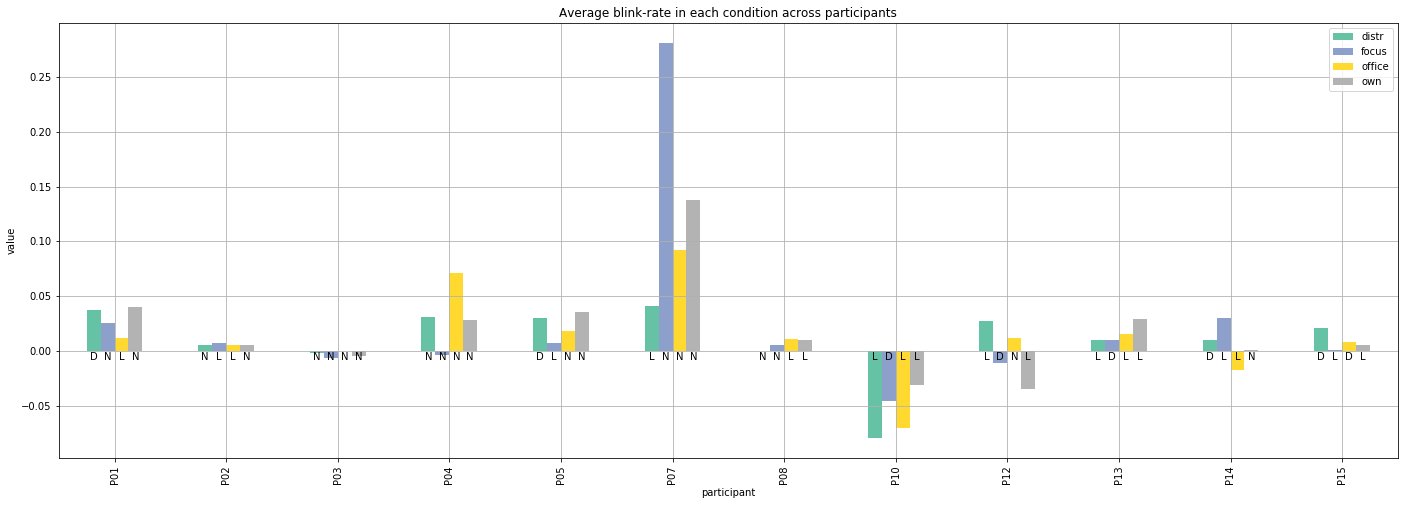

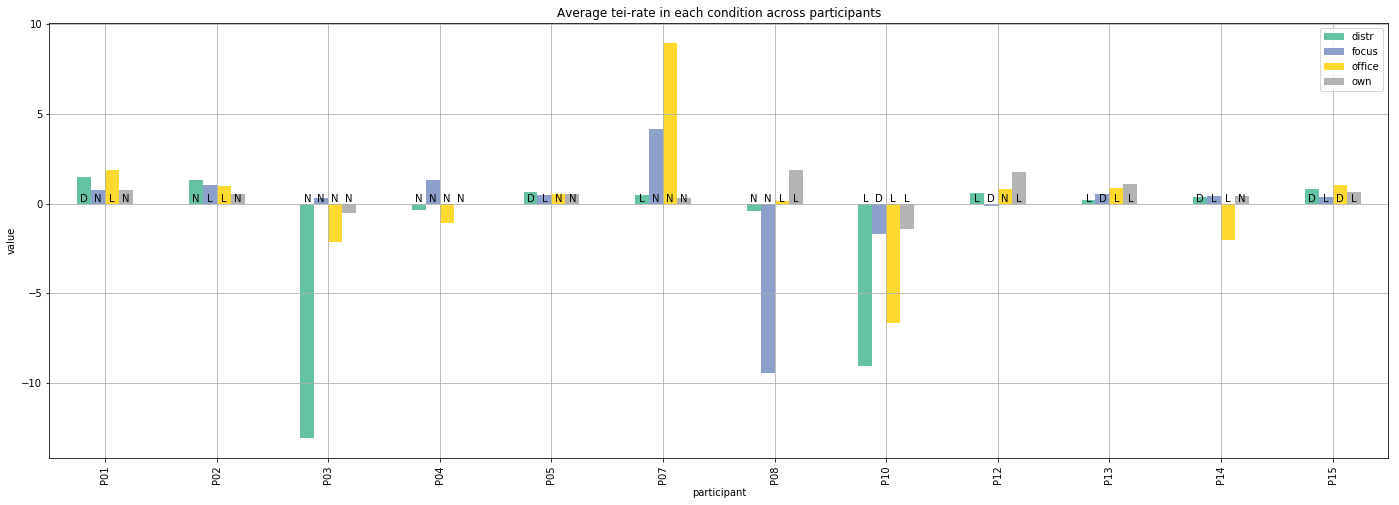

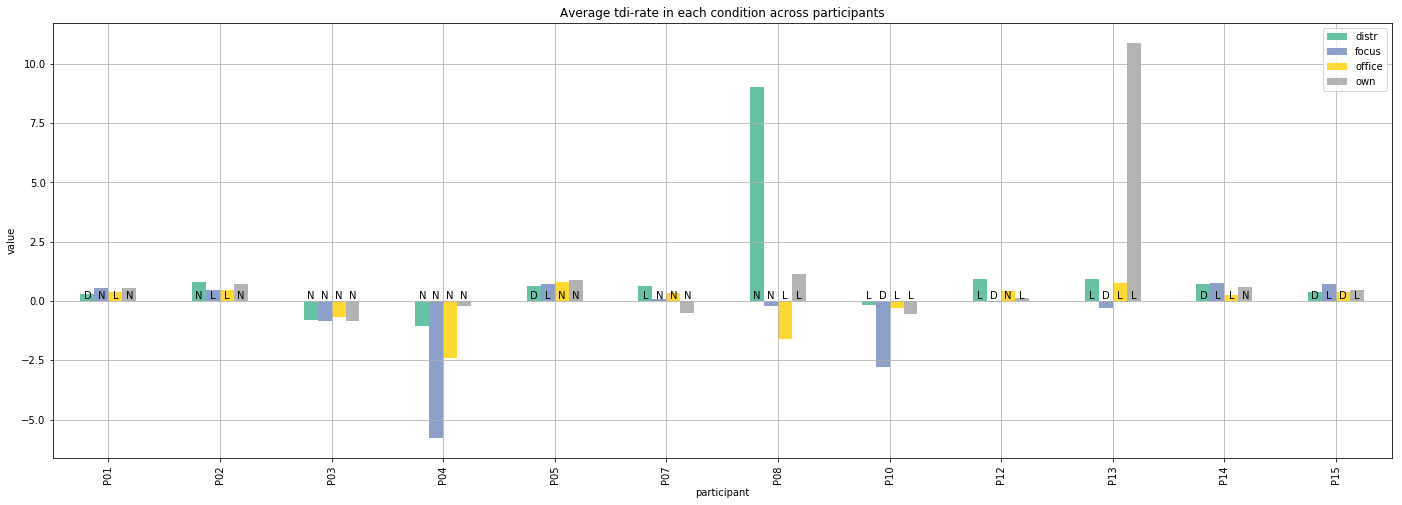

In [19]:
# average values for each condition across participants
p_ids = ['P01', 'P02', 'P03', 'P04', 'P05', 'P07', 'P08', 'P10', 'P12', 'P13', 'P14', 'P15']
comparisons = ['music_cond'] # 'programming_task'
measures = ['blink', 'tei', 'tdi']

path = 'results/csv_files/60_sec_intervals/'
for measure in measures:
    temp_df = pd.DataFrame(columns=['PID', 'focus', 'distr', 'own', 'office'])
    for p_id in p_ids:
        result_file = path + 'plot_data_' + measure + \
                      '_music_comparison_participant_' + p_id + '.csv'
        df = pd.read_csv(result_file)
        df = df[df.columns[1:]].dropna()
        avg = pd.DataFrame(df.mean()).T
        avg['PID'] = p_id
        temp_df = temp_df.append(avg, sort=True)
    titl = 'Average ' + measure + '-rate in each condition across participants'
    cmap = cm.get_cmap('Set2')
    ax = temp_df.plot.bar(x='PID', figsize=(24,8), grid=True, title=titl, colormap=cmap)
    ax.set_xlabel("participant")
    ax.set_ylabel("value")
    fig_name = path + '000_' + measure + '_comparison_condition_medians.png'
    fig = ax.get_figure()
    rects = ax.patches
    labels = ['D','N','N','N','D','L','N','L','L',
              'L','D','D','N','L','N','N','L','N',
              'N','D','D','D','L','L','L','L','N',
              'N','N','N','L','L','N','L','L','D',
              'N','N','N','N','N','N','L','L','L',
              'L','N','L']
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, -0.01, label,
                ha='center', va='bottom')
    fig.savefig(fig_name)

In [20]:
measurement = ['blink', 'tei', 'tdi']
# excluding the participants that were excluded
p_ids = ['P01', 'P02', 'P03', 'P04', 'P05', 'P07', 'P08', 'P10', 'P12', 'P13', 'P14', 'P15']

In [21]:
# load difference-files for each participant
diff_columns = ['PID', 'distr-focus avg', 'own-focus avg', 'office-focus avg', 'own-distr avg', 'office-distr avg', 
                'office-own avg'] 
avg_cols = ['distr-focus avg', 'own-focus avg', 'office-focus avg', 'own-distr avg', 'office-distr avg', 
            'office-own avg'] 
for measure in measurement:
    diff_avg_df = pd.DataFrame(columns=diff_columns)
    for p_id in p_ids:
        row = pd.DataFrame(columns=diff_columns)
        row['PID'] = [p_id]
        filename = 'results/csv_files/60_sec_intervals/music_conditions_differences_'\
        + p_id + '_' + measure + '.csv'
        diff_df = pd.read_csv(filename)
        diff_df.dropna(inplace=True)
        diff_df.rename(columns={'Unnamed: 0':'PID'}, inplace=True)
        for col in diff_df.columns[1:]:
            row[col + ' avg'] = diff_df[col].mean()
        diff_avg_df = diff_avg_df.append(row, sort=False)
    # save file to csv
    result_filename = 'results/csv_files/60_sec_intervals/00_numerical_diffs_' + measure\
    + '.csv'
    avg_diffs = diff_avg_df[avg_cols].mean(axis=0)
    print('measure')
    print(measure)
    print('avg diffs across participants')
    print(avg_diffs)
    print()
    print()


measure
blink
avg diffs across participants
distr-focus avg    -0.014020
own-focus avg      -0.006492
office-focus avg   -0.011799
own-distr avg       0.007528
office-distr avg    0.002221
office-own avg     -0.005307
dtype: float64


measure
tei
avg diffs across participants
distr-focus avg    -1.263139
own-focus avg       0.653055
office-focus avg    0.429290
own-distr avg       1.916193
office-distr avg    1.692428
office-own avg     -0.223765
dtype: float64


measure
tdi
avg diffs across participants
distr-focus avg     1.583519
own-focus avg       1.658115
office-focus avg    0.457850
own-distr avg       0.074596
office-distr avg   -1.125669
office-own avg     -1.200265
dtype: float64




Text(0,0.5,'difference')

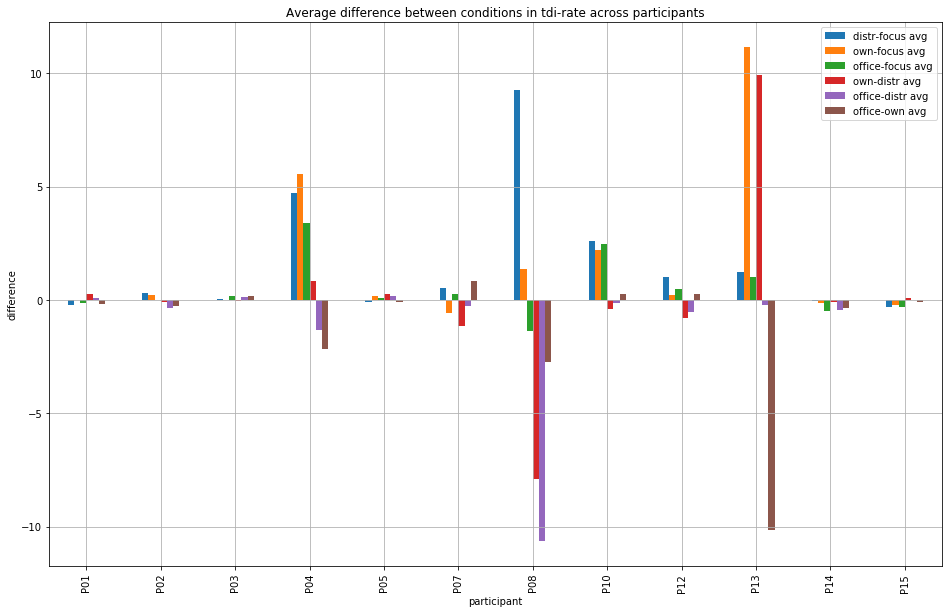

In [22]:
titl = 'Average difference between conditions in ' + measure + '-rate across participants'
ax = diff_avg_df.plot.bar(x='PID', figsize=(16,10), grid=True, title=titl)
ax.set_xlabel("participant")
ax.set_ylabel("difference")

## Grouped boxplot of avg. incl. std for each participant and each condition

In [23]:
# Load csv files for each participant, get average and std for each condition, (add to new dataframe,?) plot dataframe
cols = ['PID', 'focus avg', 'focus std', 'distr avg', 'distr std', 'own avg', 'own std', 'office avg', 'office std']
for measure in measurement:
    avg_df = pd.DataFrame(columns=cols)
    for p_id in p_ids:
        filename = 'results/csv_files/60_sec_intervals/plot_data_' + measure + \
        '_music_comparison_participant_' + str(p_id) + '.csv'
        p_df = pd.read_csv(filename)
        p_df.dropna(inplace=True)
        avg_cols = p_df.columns[1:]
        p_avg_df = p_df[avg_cols].mean(axis=0)
        p_avg_df['PID'] = p_id
        p_avg_df = pd.DataFrame(p_avg_df).T
        for col in p_df.columns[1:]:
            p_avg_df.rename(columns={col: col + ' avg'}, inplace=True)
            p_avg_df[col + ' std'] = np.std(p_df[col])
        avg_df = avg_df.append(p_avg_df, sort=True)
    print(measure)
    print(avg_df)

blink
   PID   distr avg  distr std    focus avg  focus std   office avg  \
0  P01   0.0374074        0.0    0.0257407        0.0     0.012037   
0  P02       0.005        0.0   0.00685185        0.0        0.005   
0  P03 -0.00163934        0.0  -0.00655738        0.0  2.73224e-05   
0  P04   0.0310119        0.0   -0.0037968        0.0    0.0709656   
0  P05   0.0300273        0.0   0.00693382        0.0    0.0185458   
0  P07   0.0406462        0.0     0.281389        0.0    0.0918564   
0  P08           0        0.0        0.005        0.0    0.0109259   
0  P10  -0.0799636        0.0   -0.0461506        0.0   -0.0709047   
0  P12   0.0271828        0.0   -0.0110808        0.0    0.0116606   
0  P13        0.01        0.0   0.00987553        0.0     0.015425   
0  P14  0.00985732        0.0    0.0297753        0.0   -0.0172617   
0  P15   0.0205449        0.0  0.000334499        0.0   0.00844566   

   office std      own avg  own std  
0         0.0    0.0403704      0.0  
0      

# Statistical Test
Using ANOVA RM

Preparing the data. DataFrame format: PID - condition - dependend variable

In [24]:
def anv_rm(dep_var, p_ids):
    anova_rm_df = pd.DataFrame(columns=['PID', 'cond', 'dependend_var'])
    for p_id in p_ids:
        filename = 'results/csv_files/60_sec_intervals/plot_data_' + dep_var + \
                   '_music_comparison_participant_' + str(p_id) + '.csv'
        p_df = pd.read_csv(filename)
        p_df.dropna(inplace=True)
        avg_cols = p_df.columns[1:]
        p_avg_df =  pd.DataFrame(p_df[avg_cols].mean(axis=0))
        p_avg_df['PID'] = p_id
        p_avg_df['cond'] = p_avg_df.index
        p_avg_df.rename(columns={0: 'dependend_var'}, inplace=True)
        anova_rm_df = anova_rm_df.append(p_avg_df, sort=True)
        
    aovrm = AnovaRM(data=anova_rm_df, depvar='dependend_var', subject='PID', within=['cond'])
    res = aovrm.fit()
    return res

In [25]:
p_ids = ['P01', 'P02', 'P03', 'P04', 'P05', 'P07', 'P08', 'P10', 'P12', 'P13', 'P14', 'P15'] 
anova_results_blink = anv_rm('blink', p_ids)
anova_results_tdi = anv_rm('tdi', p_ids)
anova_results_tei = anv_rm('tei', p_ids)
print('blink rate')
print(anova_results_blink)
print()
print('TDI')
print(anova_results_tdi)
print()
print('TEI')
print(anova_results_tei)

blink rate
              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
cond 3.0000 33.0000  0.3857 0.7640


TDI
              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
cond 3.0000 33.0000  1.8000 0.1664


TEI
              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
cond 3.0000 33.0000  1.0713 0.3746



---
# Renaming of files after download from SwitchDrive
---

In [ ]:
from pathlib import Path
from os import rename, rmdir
import re
from zipfile import ZipFile
import pandas as pd


# Works with Luka's naming scheme
def unzip():
    for filename in Path('data').rglob('*.zip'):
        parts = filename.parts
        with ZipFile(filename, 'r') as zipObj:
            zipObj.extractall('tmp')
        name = parts[-1]
        if re.search(r'.*break.*',name):
            name = re.sub(r'([0-9]).*dition ([0-9]).*(ID[0-9][0-9]?)\.zip', r'break\1_condition\2_\3.csv',name)
        else:
            name = re.sub(r'([0-9]).*dition ([0-9]).*(ID[0-9][0-9]?)\.zip', r'programming\1_condition\2_\3.csv',name)

        for museFile in Path('tmp').rglob('*'):
            p = museFile.parts
            rename(museFile,'data/' + name)
    rmdir('tmp')
    

# Replaces the 'XxX' placeholder with condition number e.g. focus music = 1, office = 4 ...
def addConditions(filename, participant_id):
    conditionOrder = re.search(r'.*([0-9])_.*',filename)
    conditionOrder = int(conditionOrder.group(1))
    order = getMusicOrderList()[int(participant_id) - 1] # -1 ==> the ordering of lists starts with 0
    return re.sub(r'XxX',str(order[conditionOrder - 1]),filename)
    
    

# Normalizing the naming scheme of files from Kathrin
def renameKathrin():
    for filename in Path('data').rglob('*.csv'):
        name = filename.parts[-1]
        if re.search(r'P.*',name):
            name = re.sub(r'^P([0-9]{2})_([0-9])_(.*)\.csv$', r'\3\2_conditionXxX_ID\1.csv',name)
            rename(filename,'data/'+name)
            
            # Normalize the ID numbering
            participant_id = re.search(r'.*ID([0-9][0-9]?)',name)
            participant_id = participant_id.group(1)
            participant_id = int(participant_id)            
            participant_id = str(participant_id)
            newName = re.sub(r'ID[0-9]{2}',"ID"+participant_id,name)
            
            newName = addConditions(newName, participant_id) # adds condition into the naming scheme
            rename('data/'+name,'data/' + newName)
            
    
            
# P08_1_break.csv
            
            
def getMusicOrderList():
    musicOrderList = []
    musicOrder_df = pd.read_csv('music_lookup.csv',sep=';')
    musicOrder_df.dropna(axis=0, thresh=3, inplace=True) # Tresh = 3 ==> rows/cols have 2 NA
    musicOrder_df.dropna(axis=1, thresh=3, inplace=True)

    for i in range(musicOrder_df.shape[0]):
        row = musicOrder_df.iloc[i]
        row = list(row)
        musicOrderList.append([int(condition_num) for condition_num in row[1:5]]) # '1:5' because we have 4 conditions
    return musicOrderList
        

